In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# load the sales data set
sales_data = pd.read_csv('../../Data/SalesData.csv')
sales_data.head()

# one hot encode the categories
categories_onehot = pd.get_dummies(sales_data['Category'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded1 = pd.concat([sales_data, categories_onehot], axis=1)

pharmacy_onehot = pd.get_dummies(sales_data['Pharmacy'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded = pd.concat([sales_data_encoded1, pharmacy_onehot], axis=1)


sales_data_encoded


,Date,Month,Quarter,Year,Qty,Product,Category,Pharmacy,Location,Dermafiller,...,Pharmacy 10,Pharmacy 11,Pharmacy 2,Pharmacy 3,Pharmacy 4,Pharmacy 5,Pharmacy 6,Pharmacy 7,Pharmacy 8,Pharmacy 9
0,1-11-2015,11,4,2015,2,Injection 14,Skinbooster,Pharmacy 1,London,0,...,0,0,0,0,0,0,0,0,0,0
1,1-11-2015,11,4,2015,1,Injection 14,Skinbooster,Pharmacy 1,London,0,...,0,0,0,0,0,0,0,0,0,0
2,1-11-2015,11,4,2015,1,Injection 1,Dermafiller,Pharmacy 2,Outside London M25,1,...,0,0,1,0,0,0,0,0,0,0
3,1-11-2015,11,4,2015,1,Injection 2,Dermafiller,Pharmacy 2,Outside London M25,1,...,0,0,1,0,0,0,0,0,0,0
4,1-11-2015,11,4,2015,4,Injection 14,Skinbooster,Pharmacy 2,"NorthEast, Midlands",0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68631,1-3-2022,3,1,2022,2,Facemask,Skincare,Pharmacy 5,"Scotland, Newcastle",0,...,0,0,0,0,0,1,0,0,0,0
68632,1-3-2022,3,1,2022,1,Facemask,Skincare,Pharmacy 5,NorthWest,0,...,0,0,0,0,0,1,0,0,0,0
68633,1-3-2022,3,1,2022,1,Facemask,Skincare,Pharmacy 5,London,0,...,0,0,0,0,0,1,0,0,0,0
68634,1-3-2022,3,1,2022,1,Facemask,Skincare,Pharmacy 5,London,0,...,0,0,0,0,0,1,0,0,0,0


RMSE: 773.309124462559
[ 8082.3849881  11954.07787302   482.27475379  1413.57632468
  4347.36366667  6015.68311328  8082.62465981 11540.53354365
   530.23030934  1210.41567785  4291.50583333  6882.51140224
  8152.87225505 12521.73379365]


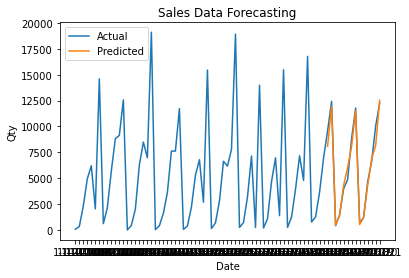

In [6]:
# group the data by date and sum the quantities and category columns
sales_data_grouped = sales_data_encoded.groupby('Date').agg({
    'Qty': 'sum',
    'Dermafiller': 'sum',
    'Mesotherapy': 'sum',
    'Needles': 'sum',
    'Profilho': 'sum',
    'Skinbooster': 'sum',
    'Skincare' : 'sum',
    'Pharmacy 1' : 'sum',
    'Pharmacy 2' : 'sum',
    'Pharmacy 3' : 'sum',
    'Pharmacy 4' : 'sum',
    'Pharmacy 5' : 'sum',
    'Pharmacy 6' : 'sum',
    'Pharmacy 7' : 'sum',
    'Pharmacy 8' : 'sum',
    'Pharmacy 9' : 'sum',
    'Pharmacy 10' : 'sum',
    'Pharmacy 11' : 'sum',
    					
})

# reset the index to make date a column again
sales_data_grouped = sales_data_grouped.reset_index()

# create lag features
sales_data_lagged = sales_data_grouped.copy()
for i in range(1, 8):
    sales_data_lagged[f'Qty_lag_{i}'] = sales_data_lagged['Qty'].shift(i)

# remove rows with missing values
sales_data_lagged.dropna(inplace=True)

# split the data into training and testing sets
train_size = int(len(sales_data_lagged) * 0.8)
train_data = sales_data_lagged[:train_size]
test_data = sales_data_lagged[train_size:]

# train a random forest model
model = RandomForestRegressor(n_estimators=100, max_depth=5)
model.fit(train_data.iloc[:, 2:], train_data['Qty'])

# make predictions for the test data
predictions = model.predict(test_data.iloc[:, 2:])

# calculate the root mean squared error (RMSE) of the predictions
rmse = ((predictions - test_data['Qty']) ** 2).mean() ** 0.5
print('RMSE:', rmse)

print(predictions)

sales_data_grouped['predicted_quantity'] = pd.Series(predictions, index=test_data.index)

# plot the actual and predicted quantities against date
plt.plot(sales_data_grouped['Date'], sales_data_grouped['Qty'], label='Actual')
plt.plot(sales_data_grouped['Date'], sales_data_grouped['predicted_quantity'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.title('Sales Data Forecasting')
plt.legend()
plt.show()


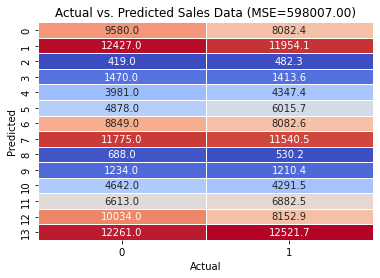

In [7]:
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error

matrix_data = np.column_stack((test_data['Qty'].values, predictions))

# calculate the mean squared error
mse = mean_squared_error(test_data['Qty'], predictions)

# plot the matrix using seaborn's heatmap function
sns.heatmap(matrix_data, annot=True, fmt='.1f', cmap='coolwarm', linewidths=.5, cbar=False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs. Predicted Sales Data (MSE={mse:.2f})')
plt.show()